In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [117]:
spx = pd.read_csv('data/^spx/history/^spx.csv')
apple = pd.read_csv('data/^spx/history/AAPL.csv')
yield_curve = pd.read_csv('data/yield-curve-rates-1990-2021.csv')
yearly_inflation = pd.read_csv('data/yearly_us_inflation.csv', sep=',')

In [118]:
yearly_inflation['inflation'] = yearly_inflation['inflation'].str.replace(",", ".").astype(float)
yearly_inflation['year'] = yearly_inflation['year'].astype(int)
yearly_inflation.head()

,year,inflation
0,1960,1.457976
1,1961,1.070724
2,1962,1.198773
3,1963,1.239669
4,1964,1.278912


In [119]:
yield_curve['date'] = pd.to_datetime(yield_curve['Date']).dt.date
yield_curve.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,date
0,12/31/21,0.06,0.05,0.06,NaN,0.19,0.39,0.73,0.97,1.26,1.44,1.52,1.94,1.90,2021-12-31
1,12/30/21,0.06,0.06,0.05,NaN,0.19,0.38,0.73,0.98,1.27,1.44,1.52,1.97,1.93,2021-12-30
2,12/29/21,0.01,0.02,0.05,NaN,0.19,0.38,0.75,0.99,1.29,1.47,1.55,2.00,1.96,2021-12-29
3,12/28/21,0.03,0.04,0.06,NaN,0.20,0.39,0.74,0.99,1.27,1.41,1.49,1.94,1.90,2021-12-28
4,12/27/21,0.04,0.05,0.06,NaN,0.21,0.33,0.76,0.98,1.26,1.41,1.48,1.92,1.88,2021-12-27


In [120]:
apple.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [125]:
apple['date'] = pd.to_datetime(apple['Data']).dt.date
apple['value'] = apple['Otwarcie']

spx['date'] = pd.to_datetime(spx['Data']).dt.date
spx['value'] = spx['Otwarcie']

df = spx[['date', 'value']].merge(apple[['date', 'value']], on='date', suffixes=('_spx',  '_appl'))
df = df.merge(yield_curve[['date', '5 Yr']], on='date')
df['year'] = pd.to_datetime(df['date']).dt.year.astype(int)

df = df.merge(yearly_inflation, on='year')

df.head()

,date,value_spx,value_appl,5 Yr,year,inflation
0,1990-01-02,353.40,0.268232,7.87,1990,5.397956
1,1990-01-03,359.69,0.289238,7.92,1990,5.397956
2,1990-01-04,358.76,0.290992,7.91,1990,5.397956
3,1990-01-05,355.67,0.287383,7.92,1990,5.397956
4,1990-01-08,352.20,0.285569,7.92,1990,5.397956


In [127]:
df.head()

,date,value_spx,value_appl,5 Yr,year,inflation,beta_official_60,beta_official_30,beta_official_12
0,1990-01-02,353.40,0.268232,7.87,1990,5.397956,NaN,NaN,NaN
1,1990-01-03,359.69,0.289238,7.92,1990,5.397956,NaN,NaN,NaN
2,1990-01-04,358.76,0.290992,7.91,1990,5.397956,NaN,NaN,NaN
3,1990-01-05,355.67,0.287383,7.92,1990,5.397956,NaN,NaN,NaN
4,1990-01-08,352.20,0.285569,7.92,1990,5.397956,NaN,NaN,NaN


In [137]:
spx_shift = df['value_spx'].shift(periods=365)
appl_shift = df['value_appl'].shift(periods=365)

df['risk_free_return'] = df['5 Yr'] - df['inflation']
df['spx_yearly_return'] = (df['value_spx'] - spx_shift) / spx_shift
df['appl_yearly_return'] = (df['value_appl'] - appl_shift) / appl_shift
df['excess_return'] = df['appl_yearly_return'] - df['risk_free_return']

In [138]:
def eval_beta(df, window, stock='appl_yearly_return', market='spx_yearly_return'):
    cov = df[[stock, market]].rolling(window).cov()
    return cov.xs(market, level=1)[stock] / cov.xs(market, level=1)[market]


df['beta_official_60'] = eval_beta(df, 365 * 5)
df['beta_official_30'] = eval_beta(df, int(365 * 2.5))
df['beta_official_12'] = eval_beta(df, 365)

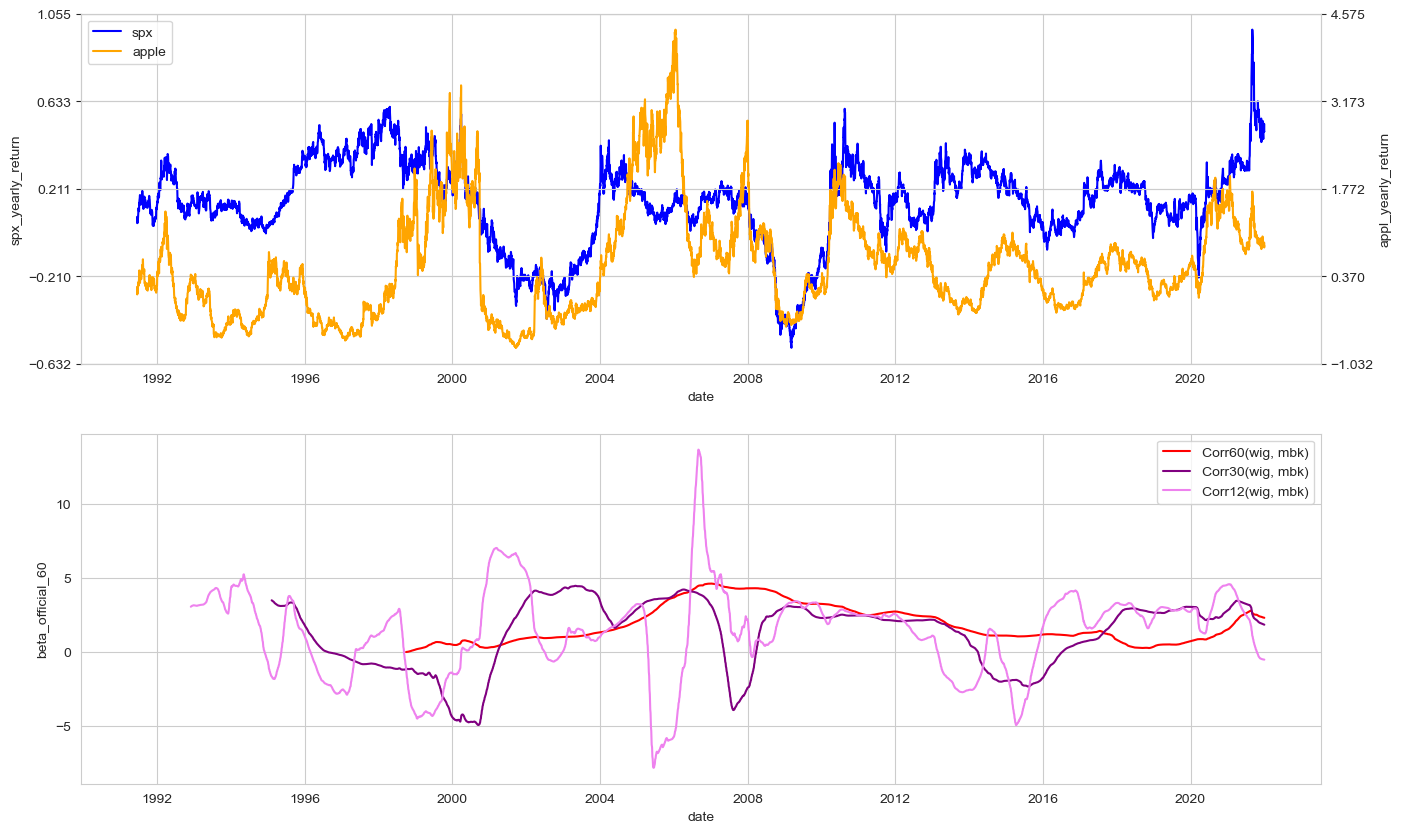

In [140]:
fig, (ax, ax2) = plt.subplots(nrows=2)

twinx = ax.twinx()

sns.lineplot(df, x='date', y='spx_yearly_return', label='spx', color='blue', ax=ax)
sns.lineplot(df, x='date', y='appl_yearly_return', label='apple', color='orange', ax=twinx)

ax_handles, ax_labels = ax.get_legend_handles_labels()
tx_handles, tx_labels = twinx.get_legend_handles_labels()
ax.legend(ax_handles + tx_handles, ax_labels + tx_labels)
twinx.get_legend().remove()

ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5))
twinx.set_yticks(np.linspace(twinx.get_ybound()[0], twinx.get_ybound()[1], 5))

sns.lineplot(df, x='date', y='beta_official_60', label='Corr60(wig, mbk)',
             color='red', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_30', label='Corr30(wig, mbk)',
             color='purple', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_12', label='Corr12(wig, mbk)',
             color='violet', ax=ax2)

ax.get_shared_x_axes().join(ax, ax2)

fig.set_size_inches(16, 10)

In [32]:
df[['beta_official_12', 'beta_official_30', 'beta_official_60']].min()

beta_official_12      3.023339
beta_official_30     85.692078
beta_official_60    211.783267
dtype: float64

In [160]:
from betas import fama_macbeth_beta

def fama_pred(ser):
    pred_df = df.loc[ser.index]
    excess_return = pred_df['excess_return'].values.reshape(-1, 1)
    market_return = pred_df['spx_yearly_return'].values.reshape(-1, 1)
    if np.isnan(market_return).sum() > 0 or np.isnan(excess_return).sum() > 0:
        return np.NaN

    return fama_macbeth_beta(excess_return, market_return)

In [161]:
df['fama_beta'] = df['appl_yearly_return'].rolling(365 * 5).apply(fama_pred).shift()

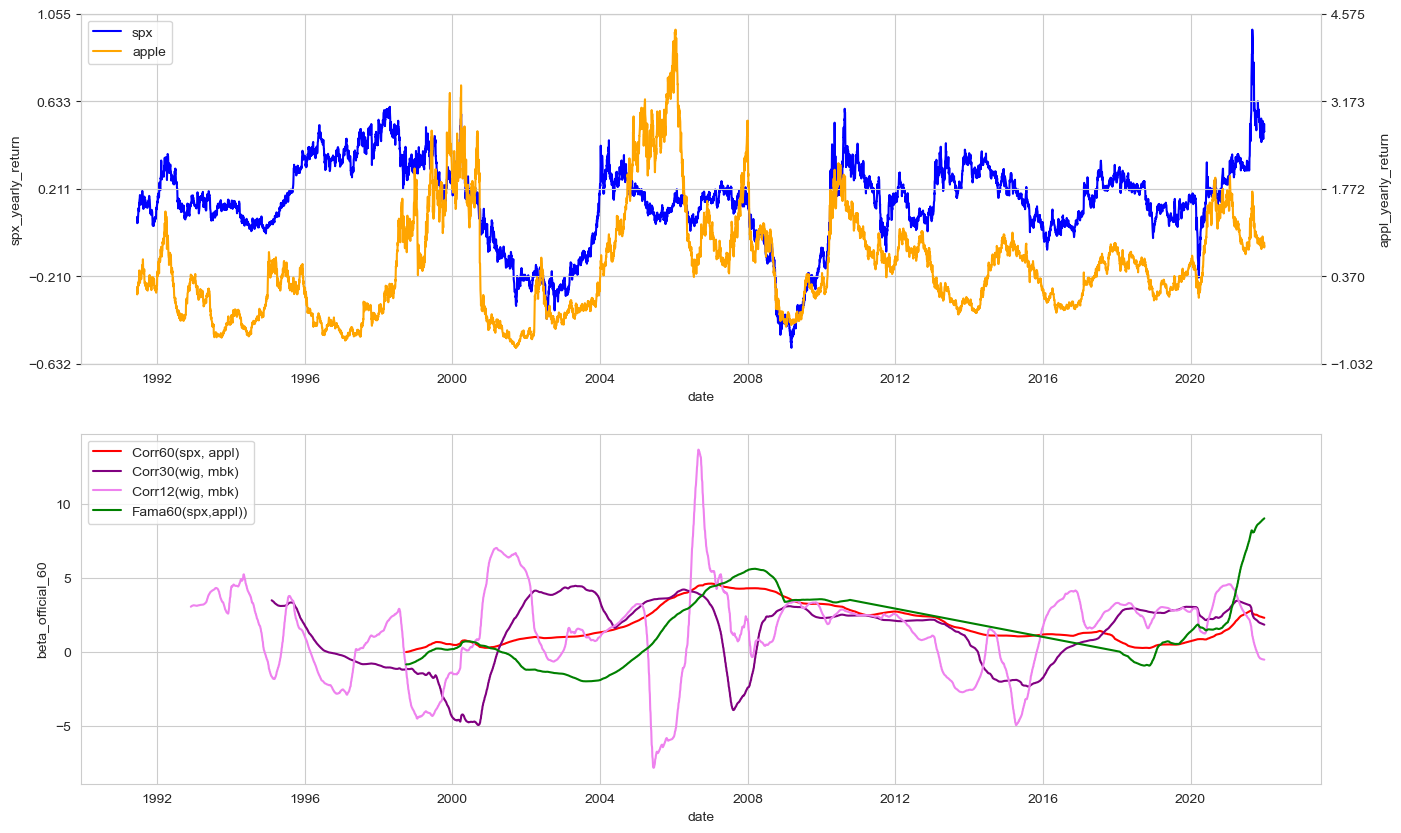

In [164]:
fig, (ax, ax2) = plt.subplots(nrows=2)

twinx = ax.twinx()

sns.lineplot(df, x='date', y='spx_yearly_return', label='spx', color='blue', ax=ax)
sns.lineplot(df, x='date', y='appl_yearly_return', label='apple', color='orange', ax=twinx)

ax_handles, ax_labels = ax.get_legend_handles_labels()
tx_handles, tx_labels = twinx.get_legend_handles_labels()
ax.legend(ax_handles + tx_handles, ax_labels + tx_labels)
twinx.get_legend().remove()

ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5))
twinx.set_yticks(np.linspace(twinx.get_ybound()[0], twinx.get_ybound()[1], 5))

sns.lineplot(df, x='date', y='beta_official_60', label='Corr60(spx, appl)',
             color='red', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_30', label='Corr30(wig, mbk)',
             color='purple', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_12', label='Corr12(wig, mbk)',
             color='violet', ax=ax2)
sns.lineplot(df, x='date', y='fama_beta', label='Fama60(spx,appl))',
             color='green', ax=ax2)


ax.get_shared_x_axes().join(ax, ax2)

fig.set_size_inches(16, 10)